# Exploración de datos

### En el cuaderno [preprocessing.ipynb](https://github.com/fake-news-unal/fake-news/blob/main/preprocessing.ipynb) se creo una base de datos SQLite con el siguiente esquema:

![Esquema base de datos](./img/graph.png)

## Lectura de datos

In [188]:
import pandas as pd
import nltk
import gensim
import sqlite3

sqlite_db = "./dataset/fake_news1.sqlite"

conn = sqlite3.connect(sqlite_db)
df_news = pd.read_sql_query("SELECT * FROM NEWS", conn)
df_subject = pd.read_sql_query("SELECT * FROM SUBJECT", conn)
df_sent = pd.read_sql_query("SELECT * FROM SENTENCE", conn)
df_entity = pd.read_sql_query("SELECT * FROM ENTITY", conn)
df_type_entity = pd.read_sql_query("SELECT * FROM TYPE_ENTITY", conn)
conn.close()

## Exploración de datos

### Se van a mostrar las tablas "NEWS", "SUBJECT", "SENTENCE", "TYPE_ENTITY" y "ENTITY". Las demás tablas no se muestran dado que la información que tienen es sobre las relaciones de "muchos a muchos" entre tablas de algunas tablas.

### La tabla "NEWS" contiene el texto de las noticias, la fecha y si estas son o no falsas, donde cada columna corresponde a:
- news_id: identificador de la noticia
- title: título de la noticia
- text: cuerpo de la noticia
- subject_id: identificador de la fuente de la noticia
- date: fecha de la noticia
- isfake: valor booleano si es falsa (0) o real (1)
- clean_joined: texto resultado del procesamiento y limpieza

Primeros registros del dataframe correspondiente a la tabla "NEWS"

In [189]:
df_news.head()

,news_id,title,text,subject_id,date,isfake,clean_joined
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,"December 29, 2017",1,military accept transgender recruit monday pen...
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,"December 31, 2017",1,senior republican senator mueller washington r...
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,"December 30, 2017",1,russia probe help australian diplomat washingt...
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,"December 29, 2017",1,trump want postal service charge amazon shipme...


Información general del dataframe correspondiente a la tabla "NEWS"

In [190]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44888 entries, 0 to 44887
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_id       44888 non-null  int64 
 1   title         44888 non-null  object
 2   text          44888 non-null  object
 3   subject_id    44888 non-null  int64 
 4   date          44888 non-null  object
 5   isfake        44888 non-null  int64 
 6   clean_joined  44888 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


Registros nulos del dataframe correspondiente a la tabla "NEWS"

In [191]:
df_news.isnull().sum()

news_id         0
title           0
text            0
subject_id      0
date            0
isfake          0
clean_joined    0
dtype: int64

### La tabla "SUBJECT" contiene los temas de las noticias, donde cada columna corresponde a:
- subject_id: identificador de la fuente de la noticia
- subject: tema de la noticia

Primeros registros del dataframe correspondiente a la tabla "SUBJECT"

In [192]:
df_subject

,subject_id,subject
0,0,Government News
1,1,politicsNews
2,2,left-news
3,3,Middle-east
4,4,worldnews
5,5,US_News
6,6,News
7,7,politics


Información general del dataframe correspondiente a la tabla "SUBJECT"

In [193]:
df_subject.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  8 non-null      int64 
 1   subject     8 non-null      object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


Registros nulos del dataframe correspondiente a la tabla "SUBJECT"

In [194]:
df_subject.isnull().sum()

subject_id    0
subject       0
dtype: int64

### La tabla "SENTENCE" contiene las oraciones de cada noticia y si esta oración corresponde a un sentimiento negativo (0), neutro (1) o positivo (2), donde cada columna corresponde a:
- sent_id: identificador de la oración
- sent_text: texto de la oración
- sentiment: sentimiento de la oración - negativo (0), neutro (1) o positivo (2)

Primeros registros del dataframe correspondiente a la tabla "SENTENCE"

In [195]:
df_sent.head()

,sent_id,news_id,sent_text,sentiment
0,0,1,"As U.S. budget fight looms, Republicans flip t...",0
1,1,1,WASHINGTON (Reuters) - The head of a conservat...,1
2,2,1,In keeping with a sharp pivot under way among ...,1
3,3,1,"“Face the Nation,” drew a hard line on federal...",1
4,4,1,When they return from the holidays on Wednesda...,0


Información general del dataframe correspondiente a la tabla "SENTENCE"

In [196]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914929 entries, 0 to 914928
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sent_id    914929 non-null  int64 
 1   news_id    914929 non-null  int64 
 2   sent_text  914929 non-null  object
 3   sentiment  914929 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Registros nulos del dataframe correspondiente a la tabla "SENTENCE"

In [197]:
df_sent.isnull().sum()

sent_id      0
news_id      0
sent_text    0
sentiment    0
dtype: int64

### La tabla "ENTITY" contiene las entidades extraídas de las noticias, donde cada columna corresponde a:
- ent_id: identificador de la entidad
- ent_text: la identidad
- type_id: llave foránea de la tabla TYPE_ENTITY para obtener el tipo de entidad

Primeros registros del dataframe correspondiente a la tabla "ENTITY"

In [198]:
df_entity.head()

,ent_id,ent_text,type_id
0,0,U.S.,0
1,1,Republicans,1
2,2,WASHINGTON,0
3,3,Reuters,2
4,4,Republican,1


Información general del dataframe correspondiente a la tabla "ENTITY"

In [199]:
df_entity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195580 entries, 0 to 195579
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ent_id    195580 non-null  int64 
 1   ent_text  195580 non-null  object
 2   type_id   195580 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


Registros nulos del dataframe correspondiente a la tabla "ENTITY"

In [200]:
df_entity.isnull().sum()

ent_id      0
ent_text    0
type_id     0
dtype: int64

### La tabla "TYPE_ENTITY" contiene los tipos de las entidades extraídas de las noticias, donde cada columna corresponde a:
- type_id: identificador del tipo de entidad
- type: el tipo de entidad

Registros del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [201]:
df_type_entity

,type_id,type
0,0,GPE
1,1,NORP
2,2,ORG
3,3,DATE
4,4,PERSON
5,5,PERCENT
6,6,MONEY
7,7,CARDINAL
8,8,ORDINAL
9,9,LAW


Información general del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [202]:
df_type_entity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type_id  18 non-null     int64 
 1   type     18 non-null     object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


Registros nulos del dataframe correspondiente a la tabla "TYPE_ENTITY"

In [203]:
df_type_entity.isnull().sum()

type_id    0
type       0
dtype: int64

## Combinación de título y texto

In [204]:
df_news['title'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script'

In [205]:
df_news['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [206]:
df_news['original'] = df_news['title'] + '. ' + df_news['text']
df_news['original'].replace("..", ".")
df_news.head()

,news_id,title,text,subject_id,date,isfake,clean_joined,original
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,"December 31, 2017",1,budget fight loom republicans flip fiscal scri...,"As U.S. budget fight looms, Republicans flip t..."
1,2,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,"December 29, 2017",1,military accept transgender recruit monday pen...,U.S. military to accept transgender recruits o...
2,3,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,"December 31, 2017",1,senior republican senator mueller washington r...,Senior U.S. Republican senator: 'Let Mr. Muell...
3,4,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,"December 30, 2017",1,russia probe help australian diplomat washingt...,FBI Russia probe helped by Australian diplomat...
4,5,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,"December 29, 2017",1,trump want postal service charge amazon shipme...,Trump wants Postal Service to charge 'much mor...


### Nota: Se debe procesar la columna "original" en vez de "clean_joined" que es la columna que tiene todo el pre-procesamiento, ya que el análisis de lenguaje natural es más impreciso sin la ortografía.

#### Muestra de la combinación anterior

In [207]:
df_news['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script. WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for no

## La noticia más reciente y más vieja:

In [208]:
df_news["parsed_date"] = pd.to_datetime(df_news['date'], infer_datetime_format=True)

### La noticia más vieja

In [209]:
df_news[df_news["parsed_date"] == df_news["parsed_date"].min()]

,news_id,title,text,subject_id,date,isfake,clean_joined,original,parsed_date
37297,37298,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,Just making room for Hillary President Obama t...,7,"Mar 31, 2015",0,flashback king obama commutes sentence drug de...,FLASHBACK: KING OBAMA COMMUTES SENTENCES OF 22...,2015-03-31
37298,37299,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,7,"Mar 31, 2015",0,apple religious freedom dangerous sell product...,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,2015-03-31
37299,37300,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",7,"Mar 31, 2015",0,watch dirty harry reid romney taxes case miss ...,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,2015-03-31
37300,37301,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,7,"Mar 31, 2015",0,guess fund shrine kennedy like political crony...,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENN...,2015-03-31
37301,37302,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,7,"Mar 31, 2015",0,benghazi panel hillary testify oath white hous...,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,2015-03-31
37302,37303,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,7,"Mar 31, 2015",0,hillary rodham nixon candidate baggage samsoni...,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,2015-03-31
43325,43326,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",2,"Mar 31, 2015",0,watch dirty harry reid romney taxes case miss ...,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,2015-03-31
43326,43327,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,The irony here isn t lost on us. Hillary is be...,2,"Mar 31, 2015",0,hillary rodham nixon candidate baggage samsoni...,HILLARY RODHAM NIXON: A CANDIDATE WITH MORE BA...,2015-03-31


### La noticia más reciente

In [210]:
df_news[df_news["parsed_date"] == df_news["parsed_date"].max()]

,news_id,title,text,subject_id,date,isfake,clean_joined,original,parsed_date
30467,30468,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",7,19-Feb-18,0,democrat senator warn mueller release finding ...,Democrat Senator Warns Mueller Not To Release ...,2018-02-19
30468,30469,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,7,19-Feb-18,0,msnbc anchor flabbergast texas teachers protec...,MSNBC ANCHOR Flabbergasted at What Texas Teach...,2018-02-19
30469,30470,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,7,19-Feb-18,0,watch snowflake communist party platform democ...,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,2018-02-19


## Total de palabras en el Dataset

In [211]:
list_of_words = []
unique_words = set()
for document in df_news.clean_joined:
    for word in gensim.utils.simple_preprocess(document):
        list_of_words.append(word)
        unique_words.add(word)

total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844932 unique_words:96134


----

# Visualización de los datos

## Gráfica de cantidad de noticias falsas y reales

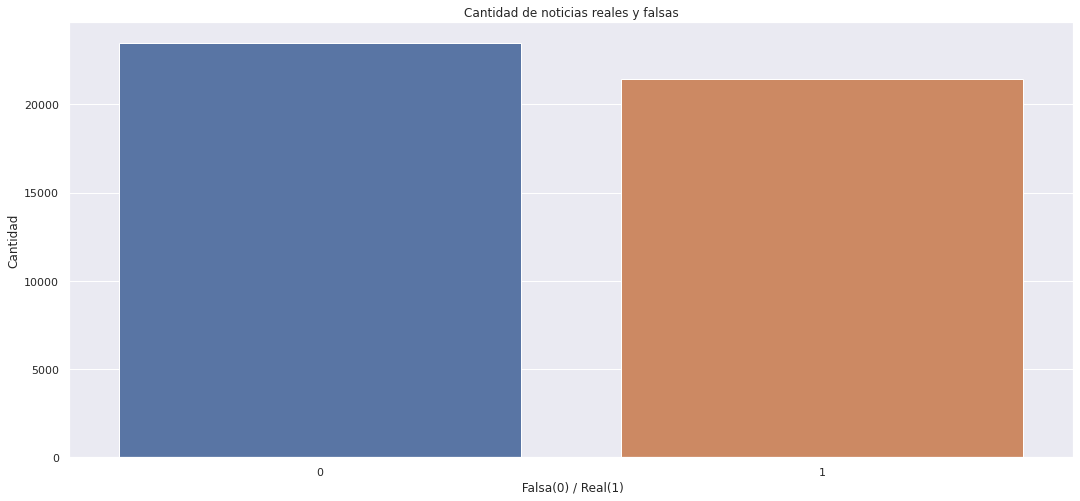

In [212]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_news, x="isfake")
plt.title('Cantidad de noticias reales y falsas')
plt.xlabel(' Falsa(0) / Real(1)')
plt.ylabel('Cantidad')
plt.show()

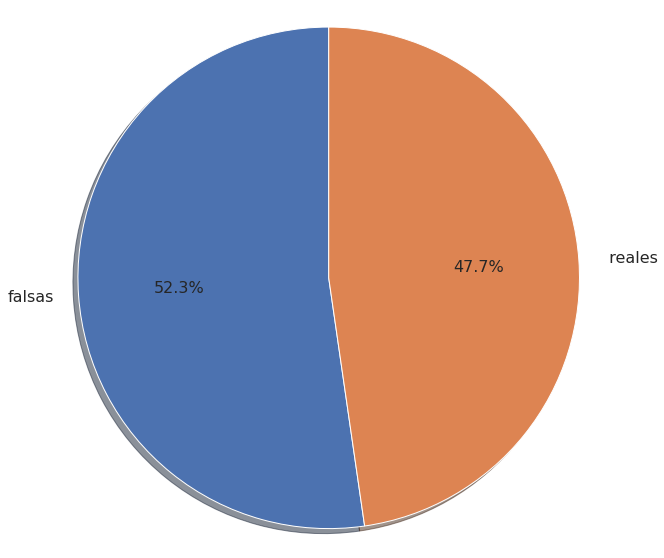

In [213]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([df_news[df_news["isfake"] == 0]["news_id"].count(), df_news[df_news["isfake"] == 1]["news_id"].count()], labels=["falsas", " reales"], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Gráfica de cantidad de noticias por tipo de la noticia

### Total

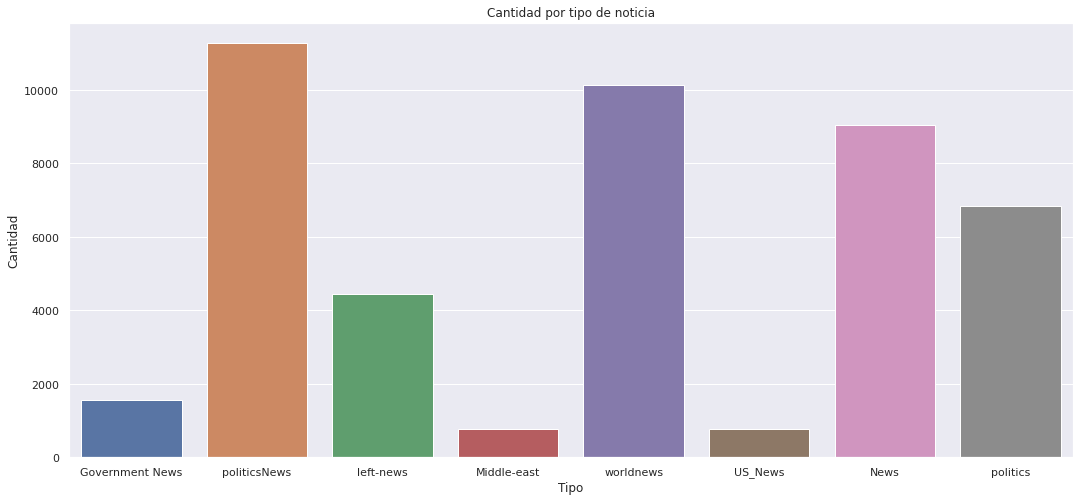

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT COUNT(*) as count, s.subject FROM NEWS n JOIN SUBJECT s ON n.subject_id = s.subject_id GROUP BY s.subject_id", conn)
conn.close()

plt.figure(figsize = (18, 8))
sns.barplot(x="subject", y="count", data=tmp_df)
plt.title('Cantidad por tipo de noticia')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.show()

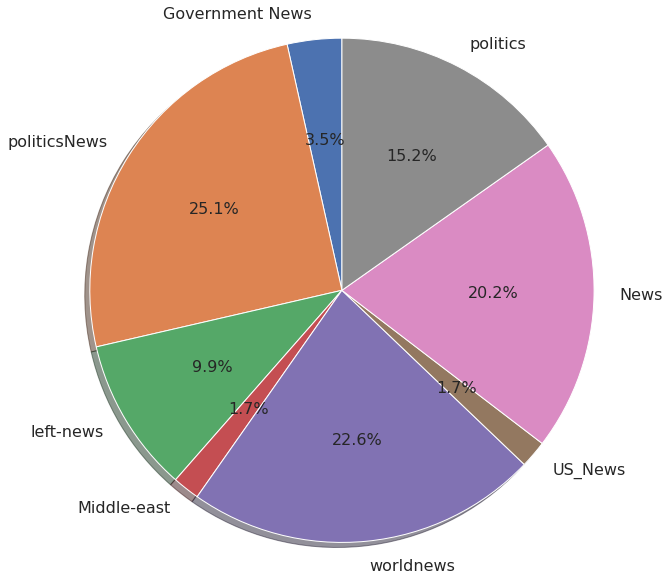

In [215]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(tmp_df["count"].tolist(), labels=tmp_df["subject"].tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal') 

plt.show()

### En noticias reales

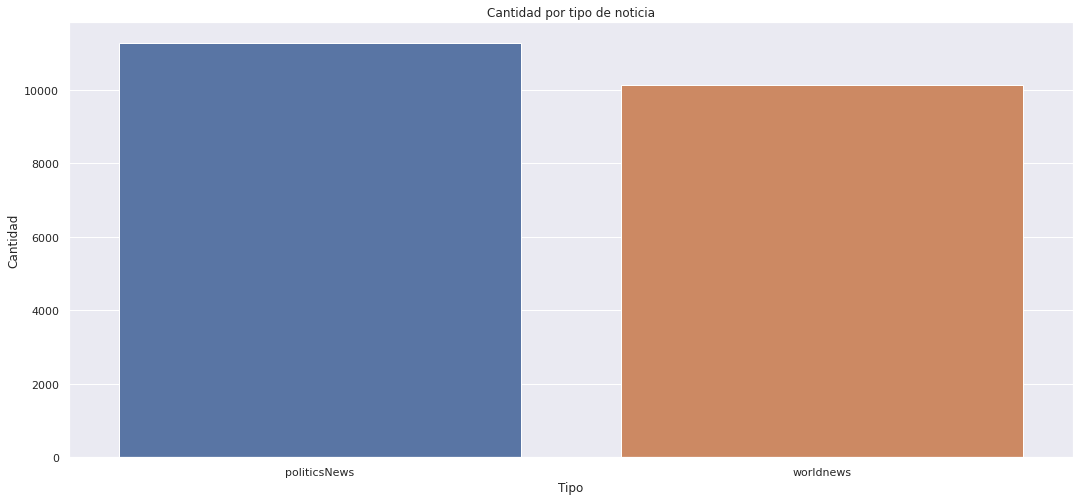

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT COUNT(*) as count, s.subject FROM NEWS n JOIN SUBJECT s ON n.subject_id = s.subject_id WHERE isfake = 1 GROUP BY s.subject_id", conn)
conn.close()

plt.figure(figsize = (18, 8))
sns.barplot(x="subject", y="count", data=tmp_df)
plt.title('Cantidad por tipo de noticia')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.show()

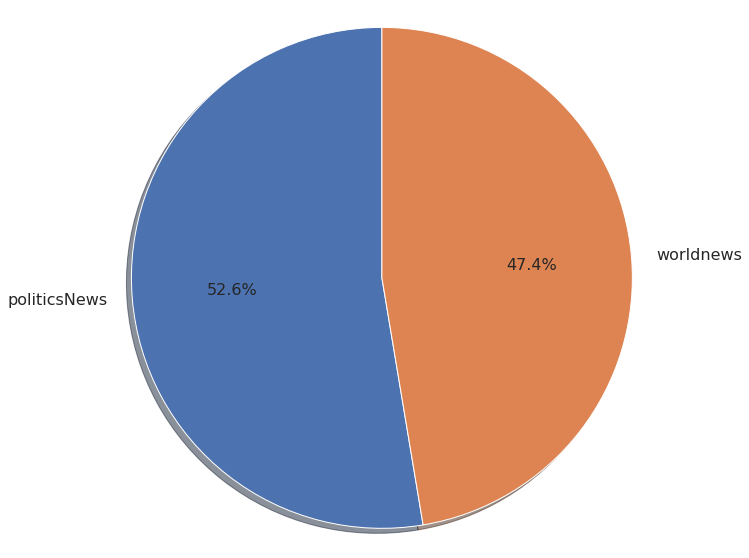

In [217]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(tmp_df["count"].tolist(), labels=tmp_df["subject"].tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal') 

plt.show()

### En noticias falsas

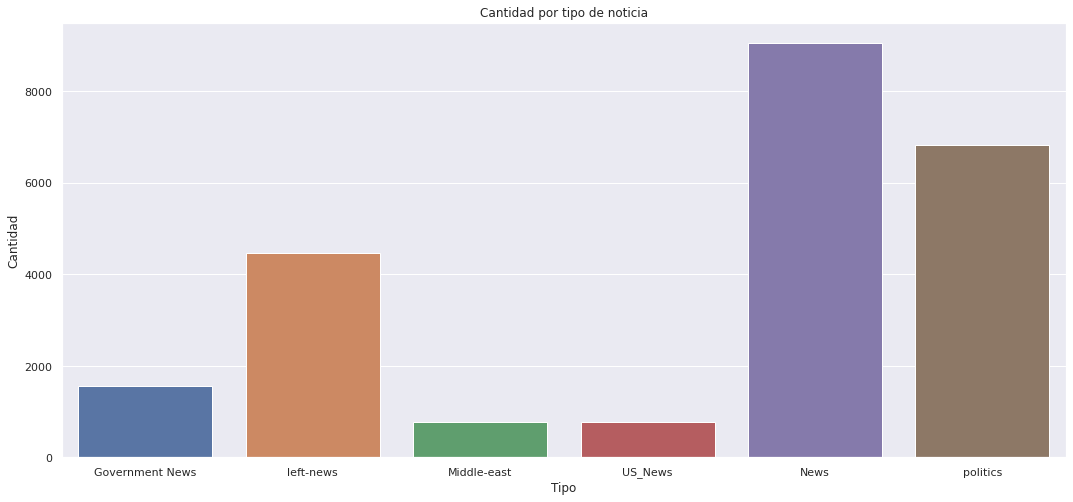

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT COUNT(*) as count, s.subject FROM NEWS n JOIN SUBJECT s ON n.subject_id = s.subject_id WHERE isfake = 0 GROUP BY s.subject_id", conn)
conn.close()

plt.figure(figsize = (18, 8))
sns.barplot(x="subject", y="count", data=tmp_df)
plt.title('Cantidad por tipo de noticia')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.show()

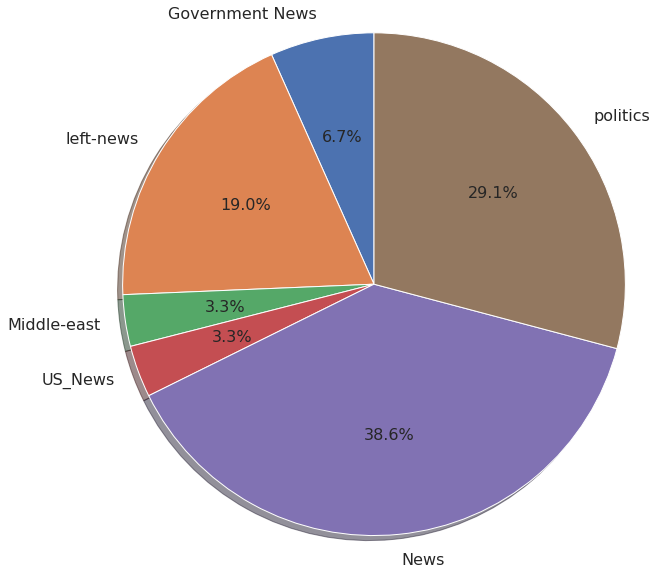

In [219]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(tmp_df["count"].tolist(), labels=tmp_df["subject"].tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  

plt.show()

## Nube de palabras de noticias reales

In [220]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))

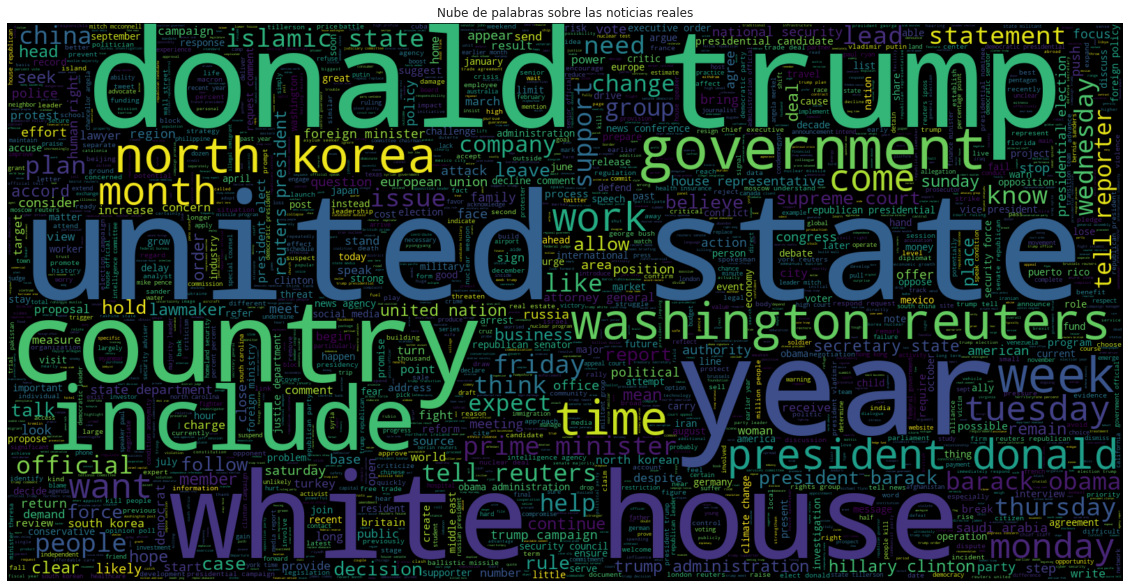

In [221]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_news[df_news.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre las noticias reales')
plt.axis("off")
plt.show()

## Nube de palabras de noticias falsas

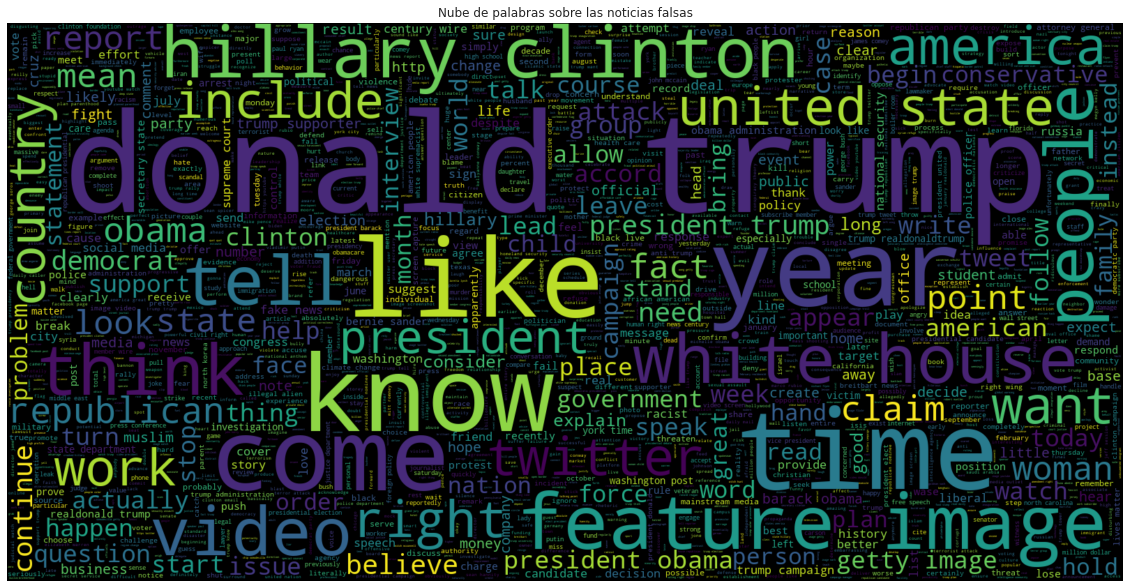

In [222]:

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_news[df_news.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre las noticias falsas')
plt.axis("off")
plt.show()

## Cantidad de oraciones

### Total

In [223]:
df_sent.sent_id.count()

914929

### En noticias reales

In [224]:
conn = sqlite3.connect(sqlite_db)
df_sent_no_fake = pd.read_sql_query("SELECT sent_id FROM SENTENCE s JOIN NEWS n ON s.news_id = n.news_id WHERE n.isfake = 1", conn)
conn.close()

df_sent_no_fake.sent_id.count()

354743

### En noticias falsas

In [225]:
conn = sqlite3.connect(sqlite_db)
df_sent_no_fake = pd.read_sql_query("SELECT sent_id FROM SENTENCE s JOIN NEWS n ON s.news_id = n.news_id WHERE n.isfake = 0", conn)
conn.close()

df_sent_no_fake.sent_id.count()

560186

### Gráfica de cantidad total de oraciones en noticias reales y falsas

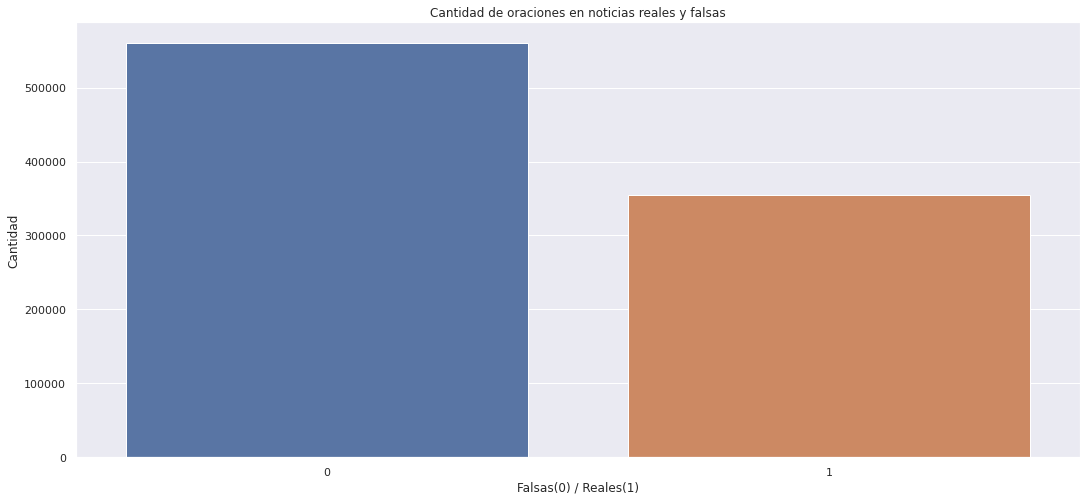

In [226]:
conn = sqlite3.connect(sqlite_db)
df_sent_all = pd.read_sql_query("SELECT sent_id, isfake, sentiment FROM SENTENCE s JOIN NEWS n ON s.news_id = n.news_id ", conn)
conn.close()

plt.figure(figsize = (18, 8))
sns.countplot(data = df_sent_all, x="isfake")
plt.title('Cantidad de oraciones en noticias reales y falsas')
plt.xlabel('Falsas(0) / Reales(1)')
plt.ylabel('Cantidad')
plt.show()

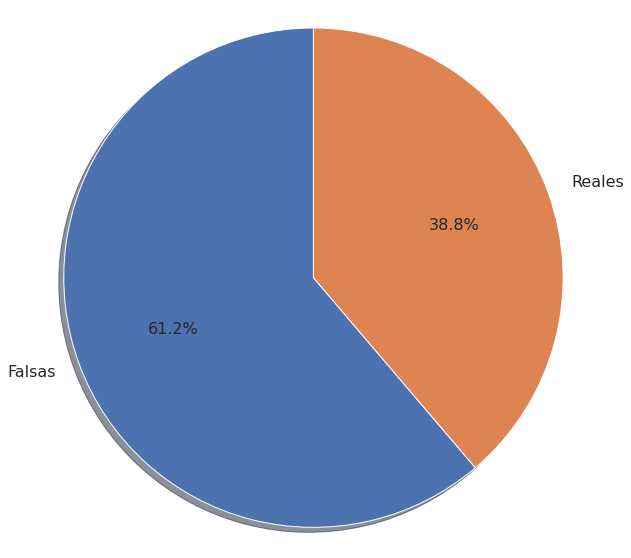

In [227]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie([df_sent_all[df_sent_all["isfake"]==0]["sent_id"].count(), df_sent_all[df_sent_all["isfake"]==1]["sent_id"].count()], labels=["Falsas", "Reales"], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  

plt.show()

### Gráfica de cantidad de oraciones por tipo de sentimiento

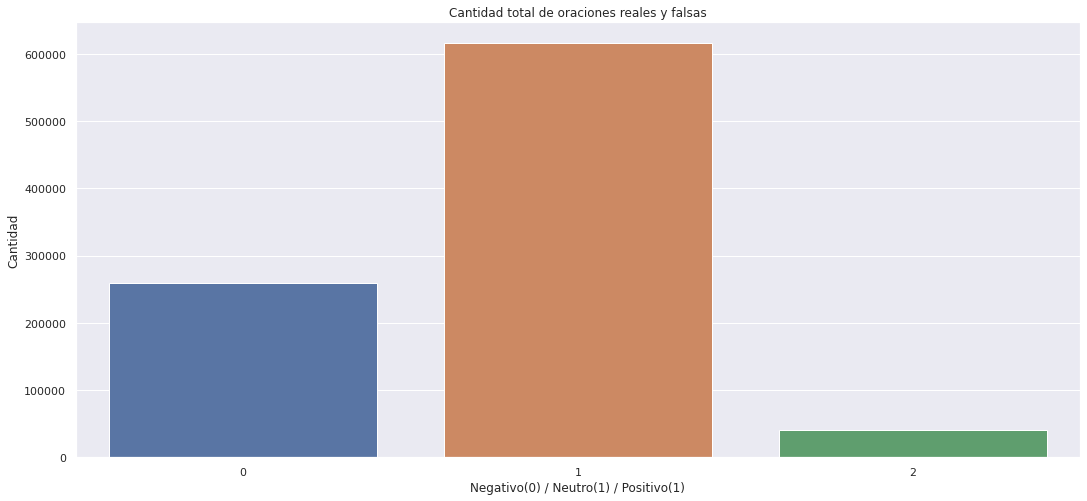

In [228]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_sent_all, x="sentiment")
plt.title('Cantidad total de oraciones reales y falsas')
plt.xlabel('Negativo(0) / Neutro(1) / Positivo(1)')
plt.ylabel('Cantidad')
plt.show()

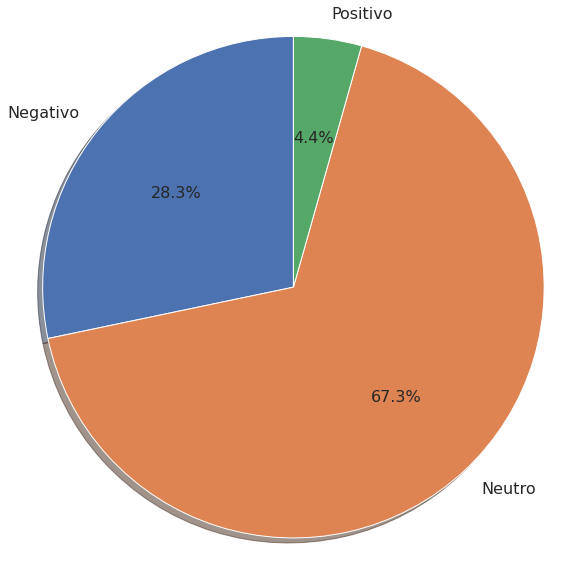

In [229]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(df_sent_all.groupby(by=["sentiment"]).count().sent_id.tolist(), labels=["Negativo", "Neutro", "Positivo"], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  

plt.show()

### Gráfica de cantidad de oraciones por tipo de sentimiento en noticias reales

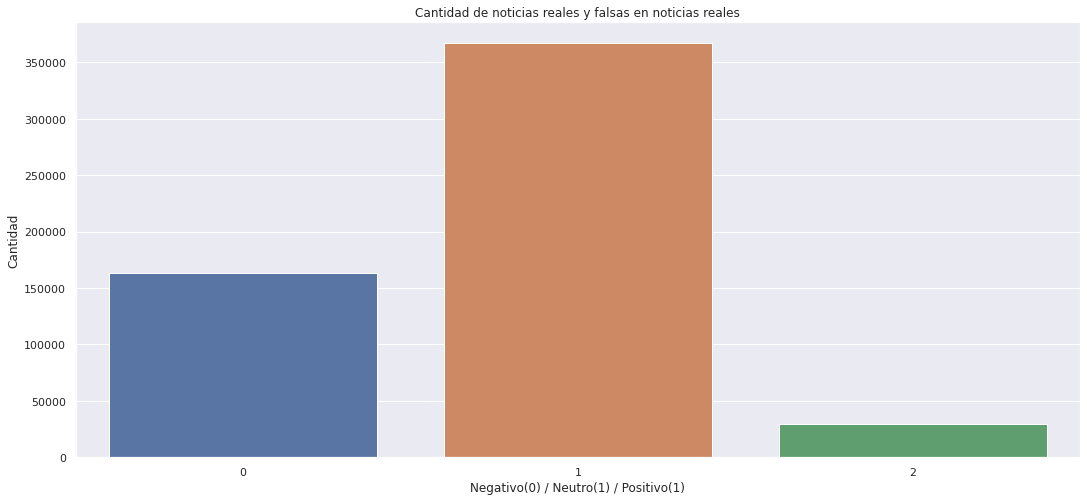

In [230]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_sent_all[df_sent_all["isfake"] == 0], x="sentiment")
plt.title('Cantidad de noticias reales y falsas en noticias reales')
plt.xlabel('Negativo(0) / Neutro(1) / Positivo(1)')
plt.ylabel('Cantidad')
plt.show()

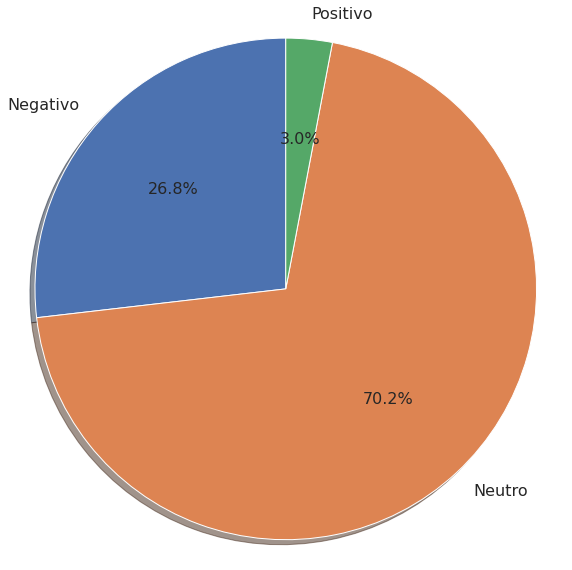

In [231]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(df_sent_all[df_sent_all["isfake"] == 1].groupby(by=["sentiment"]).count().sent_id.tolist(), labels=["Negativo", "Neutro", "Positivo"], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  

plt.show()

### Gráfica de cantidad de oraciones por tipo de sentimiento en noticias Falsas

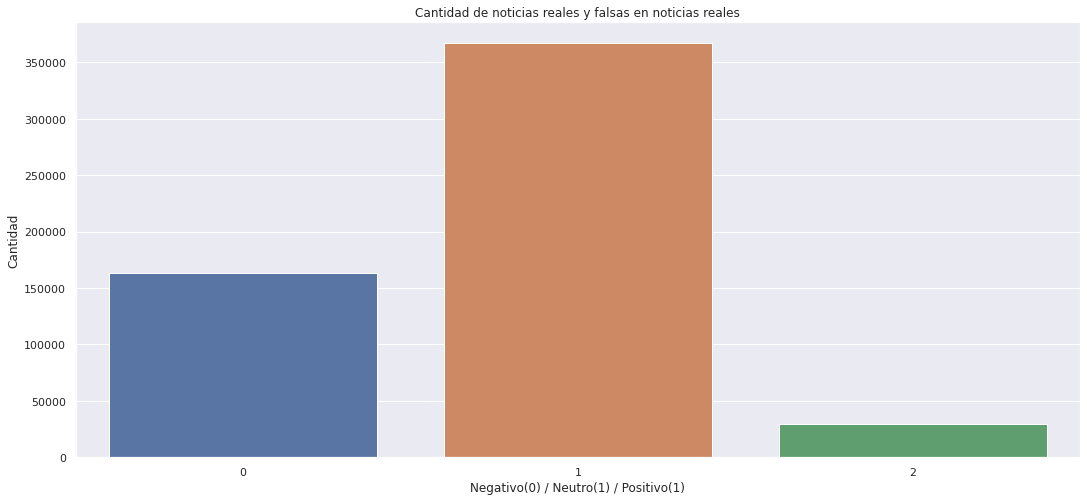

In [232]:
plt.figure(figsize = (18, 8))
sns.countplot(data = df_sent_all[df_sent_all["isfake"] == 0], x="sentiment")
plt.title('Cantidad de noticias reales y falsas en noticias reales')
plt.xlabel('Negativo(0) / Neutro(1) / Positivo(1)')
plt.ylabel('Cantidad')
plt.show()

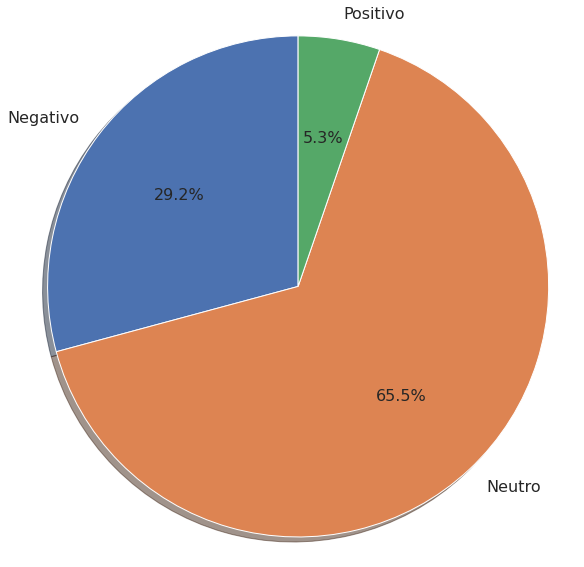

In [233]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(df_sent_all[df_sent_all["isfake"] == 0].groupby(by=["sentiment"]).count().sent_id.tolist(), labels=["Negativo", "Neutro", "Positivo"], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  

plt.show()

## Cantidad de Entidades:

In [234]:
df_entity["ent_id"].count()

195580

### Gráfica del top 15 de las entidades que más aparecen en el total de noticias

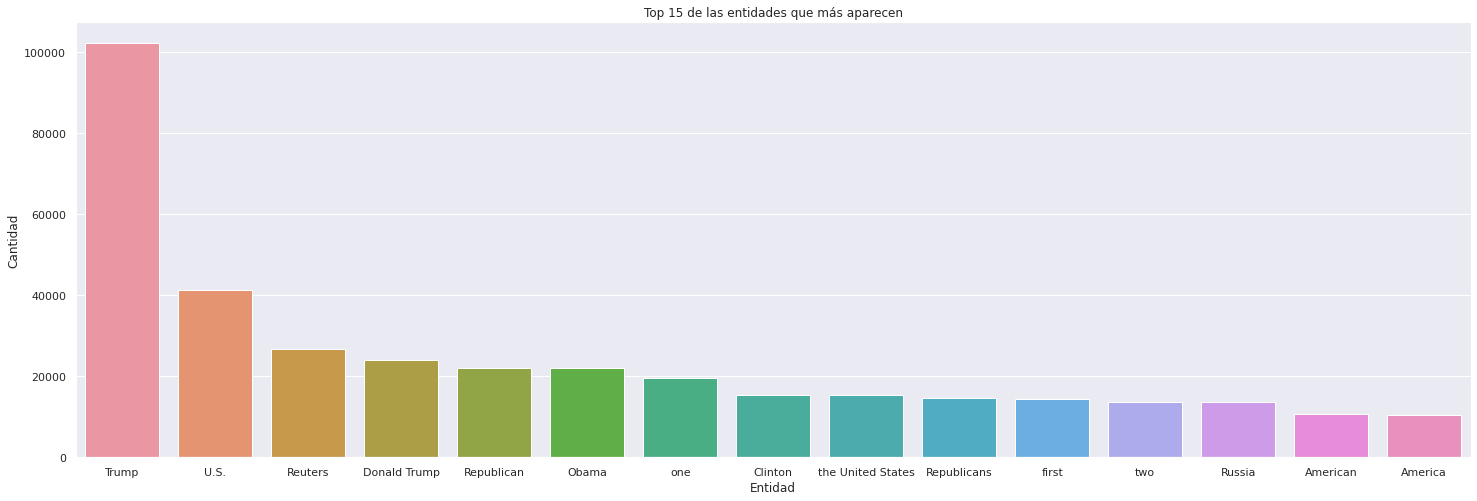

In [235]:
conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT count(*) as count, ent_text FROM SENTENCE_ENTITY se JOIN ENTITY e ON se.ent_id = e.ent_id  GROUP BY e.ent_id ORDER BY count DESC", conn)
conn.close()

plt.figure(figsize = (25, 8))
sns.barplot(x="ent_text", y="count", data=tmp_df.head(15))
plt.title('Top 15 de las entidades que más aparecen')
plt.xlabel('Entidad')
plt.ylabel('Cantidad')
plt.show()

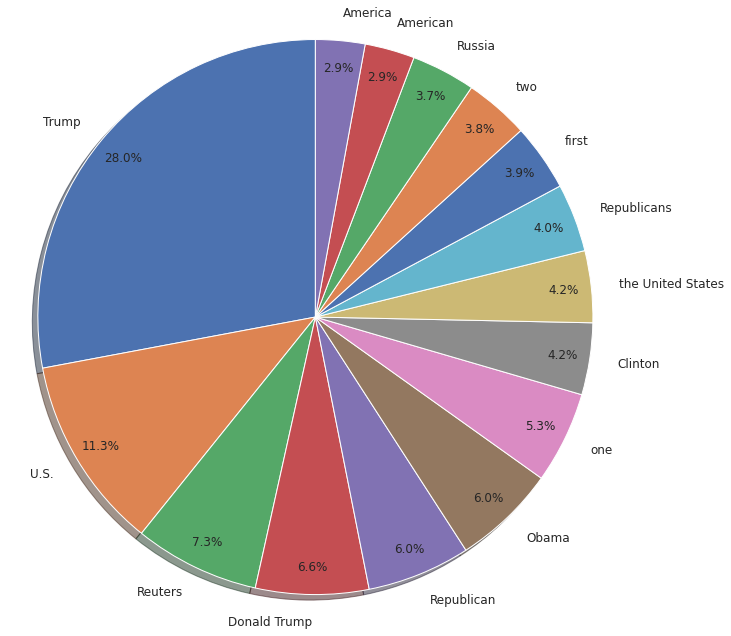

In [236]:
fig1, ax1 = plt.subplots(figsize=(11, 11))
ax1.pie(tmp_df["count"].head(15).tolist(), labels=tmp_df["ent_text"].head(15).tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=0.9)
ax1.axis('equal')  

plt.show()

### Gráfica del top 15 de las entidades que más aparecen en las noticias reales

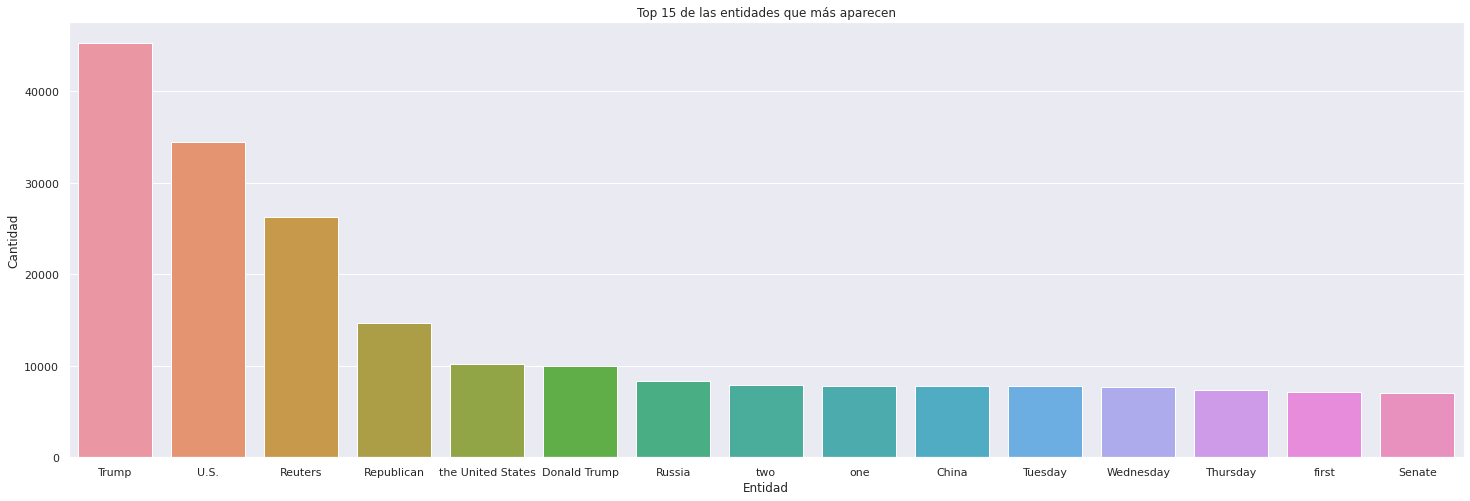

In [237]:
conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT count(*) as count, ent_text FROM SENTENCE_ENTITY se JOIN ENTITY e ON se.ent_id = e.ent_id JOIN SENTENCE s on se.sent_id = s.sent_id JOIN NEWS n on s.news_id = n.news_id WHERE n.isfake = 1 GROUP BY e.ent_id ORDER BY count DESC", conn)
conn.close()

plt.figure(figsize = (25, 8))
sns.barplot(x="ent_text", y="count", data=tmp_df.head(15))
plt.title('Top 15 de las entidades que más aparecen')
plt.xlabel('Entidad')
plt.ylabel('Cantidad')
plt.show()

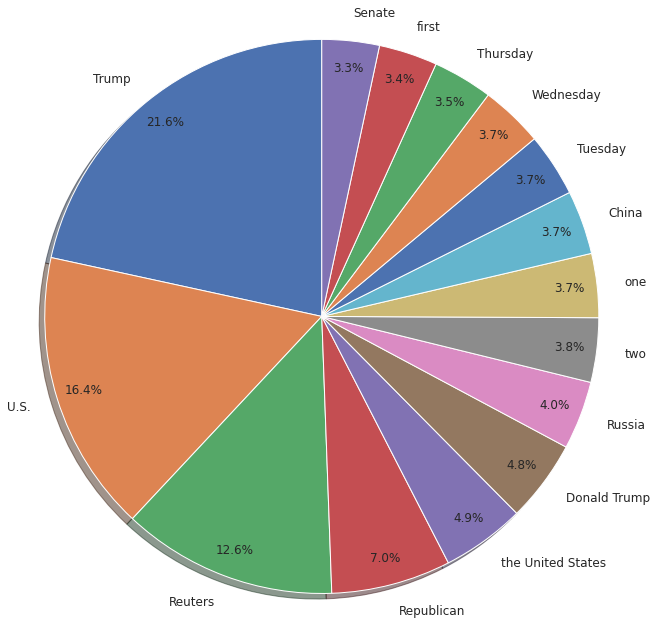

In [238]:
fig1, ax1 = plt.subplots(figsize=(11, 11))
ax1.pie(tmp_df["count"].head(15).tolist(), labels=tmp_df["ent_text"].head(15).tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=0.9)
ax1.axis('equal')  

plt.show()

### Gráfica del top 15 de las entidades que más aparecen en las noticias falsas

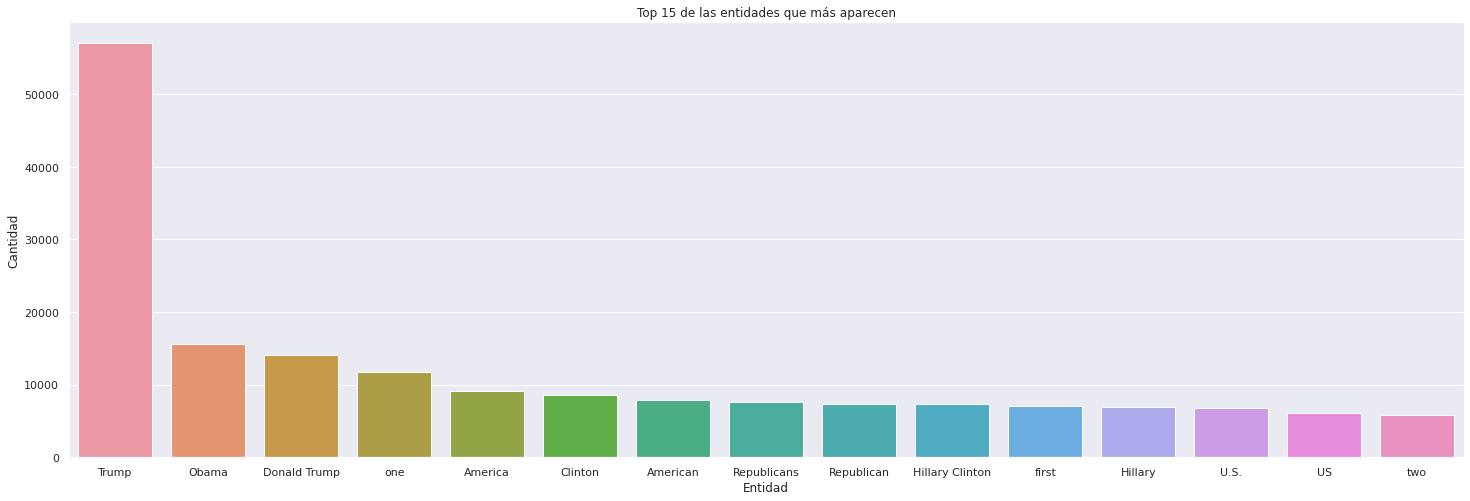

In [239]:
conn = sqlite3.connect(sqlite_db)
tmp_df = pd.read_sql_query("SELECT count(*) as count, ent_text, isfake FROM SENTENCE_ENTITY se JOIN ENTITY e ON se.ent_id = e.ent_id JOIN SENTENCE s on se.sent_id = s.sent_id JOIN NEWS n on s.news_id = n.news_id WHERE n.isfake = 0 GROUP BY e.ent_id ORDER BY count DESC", conn)
conn.close()

plt.figure(figsize = (25, 8))
sns.barplot(x="ent_text", y="count", data=tmp_df.head(15))
plt.title('Top 15 de las entidades que más aparecen')
plt.xlabel('Entidad')
plt.ylabel('Cantidad')
plt.show()

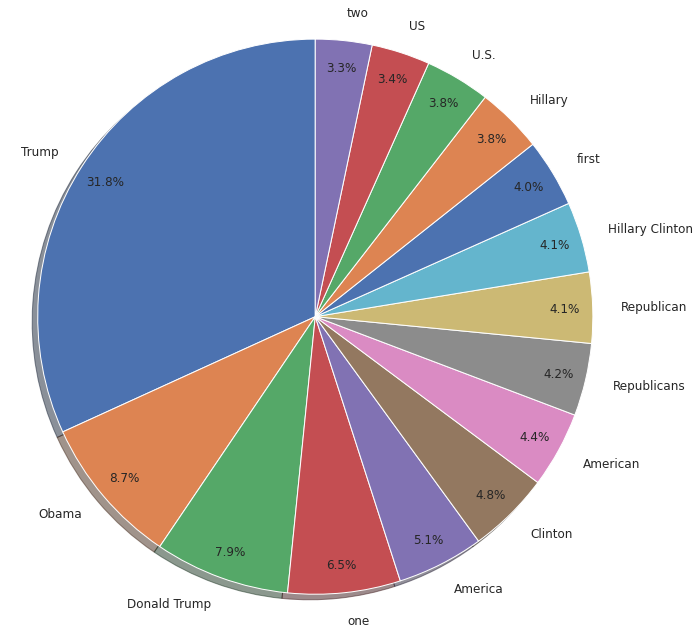

In [240]:
fig1, ax1 = plt.subplots(figsize=(11, 11))
ax1.pie(tmp_df["count"].head(15).tolist(), labels=tmp_df["ent_text"].head(15).tolist(), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=0.9)
ax1.axis('equal')  

plt.show()



### Tipos de entidades

| <span style="font-size:larger;float:left;">Tipo</span> |  <span style="font-size:larger;">Descripción</span> |
|---|---|
| GPE | Países, ciudades o estados |
| NORP | Nacionalidades, grupos políticos o religiosos |
| ORG | Compañías, agencias o instituciones |
| DATE | Periodos y fechas |
| PERSON | Personas incluyendo ficción |
| PERCENT | Porcentajes | 
| MONEY | Valores monetarios |
| CARDINAL | Números | 
| ORDINAL | Números en letras "first", "second", etc | 
| LAW | Documentos nombrados que representan leyes |
| WORK_OF_ART | Títulos de libros, canciones, etc |
| TIME | Tiempos que son inferiores a un día |
| FAC | Construcciones, edificios, avenidas, etc. |
| LOC | Ubicaciones diferentes a GPE como ríos, montanas, etc |
| EVENT | Huracanes, batallas, guerras, eventos deportivos, etc | 
| QUANTITY | Medidas como pesos o distancias |
| PRODUCT | Objetos, carros, comida, etc (servicios no) |
| LANGUAGE | Cualquier idioma mencionado |



### Gráfica de cantidad de entidades por tipo de entidad

In [241]:
df_join_ent_type = df_entity.join(df_type_entity, on='type_id', lsuffix='_entity', rsuffix='_type')
fd_group_ent_type = df_join_ent_type.groupby(by=["type"]).count()
fd_group_ent_type_index = fd_group_ent_type["ent_id"].copy()
fd_group_ent_type.index.name = "type"
fd_group_ent_type.reset_index(inplace=True)
fd_group_ent_type = fd_group_ent_type[["ent_id", "type"]].rename(columns={'ent_id':'count'}).sort_values(by=['count'], ascending=False)

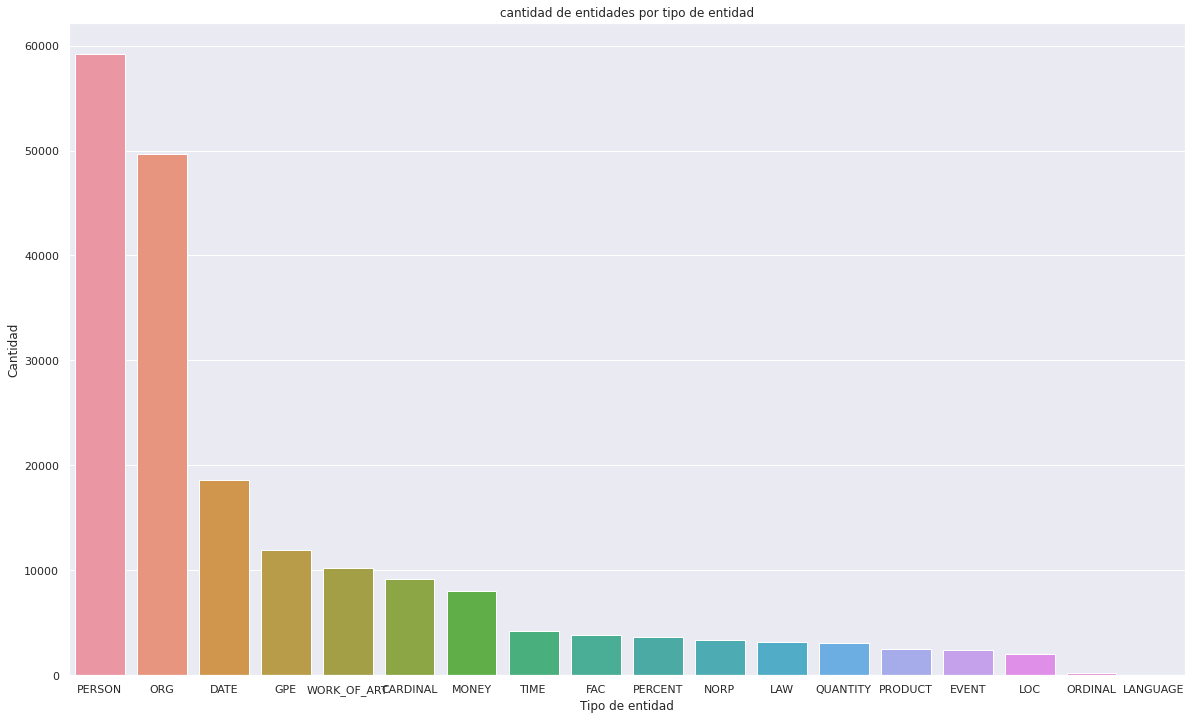

In [242]:
plt.figure(figsize = (20,12))
sns.barplot(x="type", y="count", data=fd_group_ent_type)
plt.title('cantidad de entidades por tipo de entidad')
plt.xlabel('Tipo de entidad')
plt.ylabel('Cantidad')
plt.show()

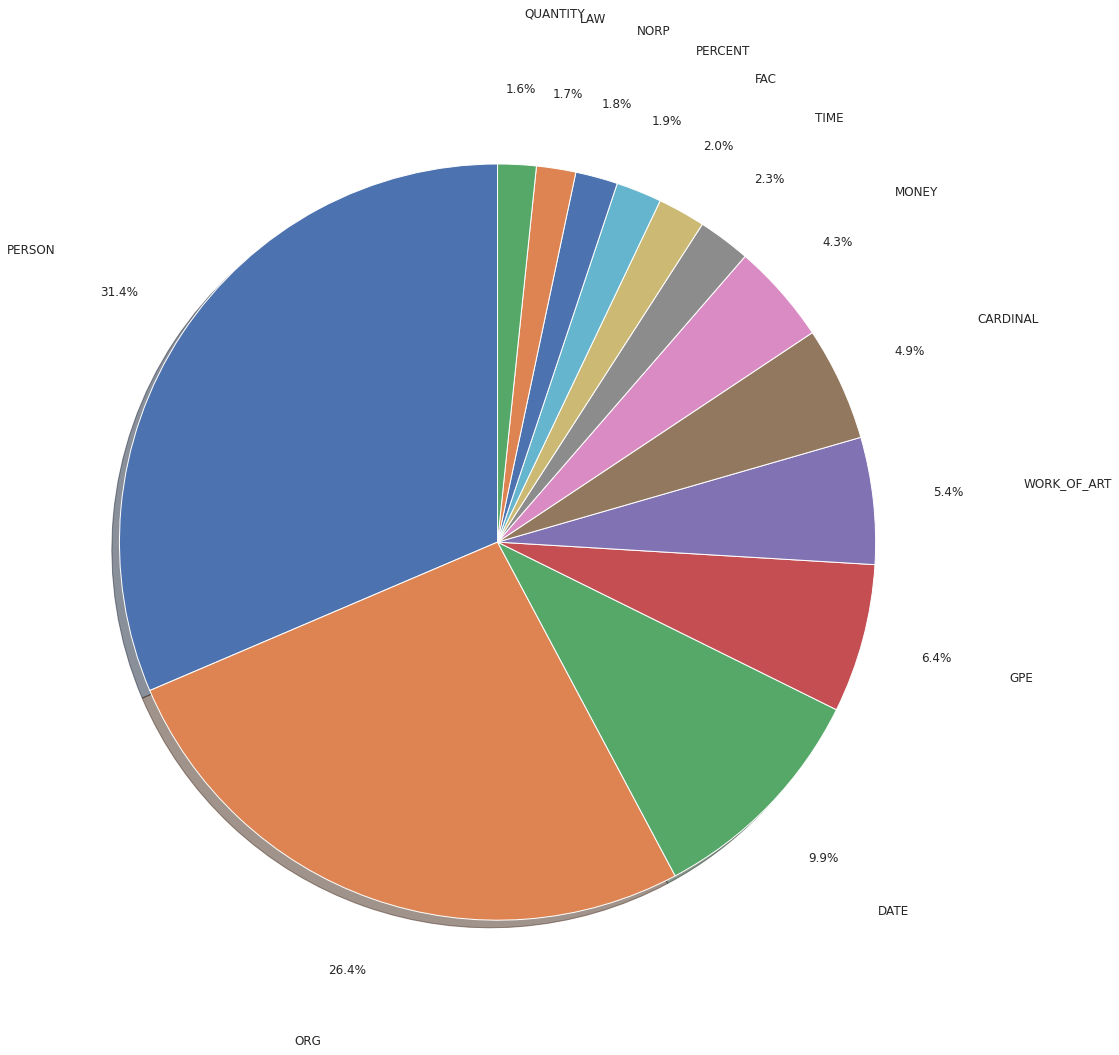

In [243]:
fig1, ax1 = plt.subplots(figsize=(15, 15))
ax1.pie(fd_group_ent_type["count"].tolist()[0:13], labels=fd_group_ent_type["type"].tolist()[0:13], autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 12},pctdistance=1.2, labeldistance=1.4)
ax1.axis('equal')  

plt.show()